<a href="https://colab.research.google.com/github/nadavo11/K_means_cluster/blob/master/EM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMM implementation


The Gaussian Mixture Model is a statistical model that assumes that the observations follow a normal distribution, ie $f(x|z)$ is a Gaussian distribution with expectation $µ_Z$ and covariance matrix $Σ_Z$. The random variable $Z$
is a hidden variable.


#### our data generator: 

after implementing the MLE algorithm, we will use it to cluster data that we will generate using the gaussian data generator (from exercise 0).

Let us define the datapiont generator:

In [67]:

import numpy as np
import matplotlib.pyplot as plt


def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster

In [10]:
def generate_clusters(n,k,d):
    colors =[]
    clusters = []
    # for k clusters:
    for i in range (k):
        cluster = generate_gaussian_cluster(get_random_gaussian_dist(d),n[i],d = d)
        clusters.append([cluster])
        #colors.append(np.random.uniform(0,1)/4+3*k/4)
    return clusters



now we will make a dataset

now, lets plot the data (revealing the source of each data point) 

In [23]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(data[:,:,0], data[:,:, 1],  alpha=0.5)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## MLE Overview

this time we will use the MLE algorithm to cluster the data.

pseudo code: The MLE algorithm goes as follows

here is MLE algorithm in pseudo code

1.until convergence, repeat:
    
   #### E-step:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

#### M-step:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$
        
        
this is what the implementation looks like:

In [105]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def MLE(data, initial_model, case = 2, plot = True):
    d = data.shape[1]

    # 1. Initialize model parameters

    phi, mu, sigma = initial_model

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]



    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        if case == 1:
            PHI, SIGMA = phi, sigma
            _, mu, _ = M_step(data, w, phi, mu, sigma)
            phi, sigma = PHI, SIGMA
        if case == 2:
            phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        
        # Plot:
        if plot:
            if i%20 == 0 or i < 4:
                if d == 2:
                    plt.scatter(data[:,0], data[:, 1], c=1+w[0]-w[1], alpha=0.5,cmap='RdYlBu')
                    plt.title("iteration #" + str(i))
                    plt.show()
                if d == 3:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(data[:,0], data[:, 1], data[:, 2], c=1+w[0]-w[1], alpha=0.5,cmap='RdYlBu')
                    plt.title("iteration #" + str(i))
                    plt.show()
        else:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            for k in range(len(phi)):
                clust = data[np.where(w[k] == np.amax(w[k]))]
                ax.scatter(clust[:,0], clust[:, 1], clust[:, 2], alpha=0.5,cmap='RdYlBu')

            #print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.0001)
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood




### Initial Model:

first, we will need an initial model to start with.  algorithm demands initial value  $\theta_0$ ie. initial values
for:  $\mu_j , \sigma^2_j , \phi_j$

one idea would be to use K-means algorithm to initialize the means of the model. we will experiment with tat later, but first we will try initiating with an arbitrary choise, as such:

In [115]:
def initial_model(k,d,*args):
    """

    :param c: # of Gaussians in model
    :param d: # of dimentions of datapoints

    :return: an arbitrary initial condition  model for MLE. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])

    if len(args) == 0:
        phi = np.random.rand(k)
        phi /= sum(phi)


        sigmas = np.zeros((k,d,d))

        for i in range(k):
            sigma = np.random.rand(d, d)
            sigma = np.dot(sigma, sigma.T)
            sigmas[i] = sigma
        print("initiating a random model...")

    else:
        phi, sigmas = args
        print("initiating a model with given phi,sigma...")
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

## convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$


and compare to previous value, to check for convergence.

In [85]:
def plot_log_likelihood(lol):
    plt.plot(range(len(lol[2:])),lol[2:])
    plt.title("log likelyhood vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|log liklyhood|")
    plt.show()

# Case I:
#### $\phi$ and $\sigma$ are known,
here there is no need to update the variables responsible to the "shape" of the distribution, i.e. the covariance matrix $\sigma$ and the amplitude $\phi$  we are looking for the centroids, $\mu$


in case 1,we are given the variance matrecies, ie.
$$\Sigma_1 = \begin{bmatrix}
0.6 & 0 \\
0 & 0.6
\end{bmatrix}
,
\Sigma_2 = \begin{bmatrix}
0.8 & -0.3 \\
-0.3 & 0.6
\end{bmatrix}$$
we are also given the probability for the first label:

$$\phi_1 = P_Z(1) = 0.7$$

and we only use the MLE algorithm to find the means for each of the clusters.
$$\mu_1 = \begin{bmatrix}
a \\
b
\end{bmatrix}
,
\mu_2 = \begin{bmatrix}
c \\
d
\end{bmatrix}$$






### generate the data

In [52]:
k=2         # number of clusters
d=2         # number of dimentions
N = 500    # number of datapoints

phi = [0.7, 0.3]
sigma = [np.array([[0.6,0],[0,0.6]]),np.array([[0.8,-0.3],[-0.3,0.6]])]
mu = [np.array([1,1]),np.array([-1,-1])]
distribution_1 = (mu[0],sigma[0])
distribution_2 = (mu[1],sigma[1])

cluster_1 = generate_gaussian_cluster(distribution_1,int(phi[0]*N),d)
cluster_2 = generate_gaussian_cluster(distribution_2,int(phi[1]*N),d)

data = np.concatenate((cluster_1,cluster_2),axis=0)

### plot the data

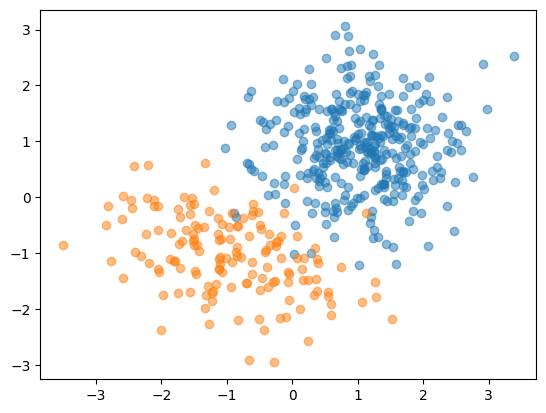

In [53]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(cluster_1[:,0], cluster_1[:, 1],  alpha=0.5)
plt.scatter(cluster_2[:,0], cluster_2[:, 1],  alpha=0.5)
plt.show()

### plot the data without assignment to clusters

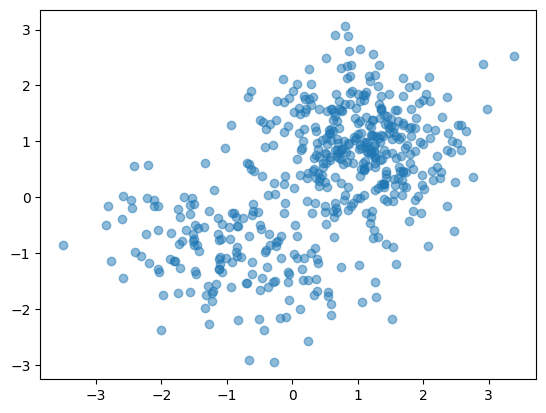

In [54]:
plt.scatter(data[:,0], data[:, 1],  alpha=0.5)
plt.show()

### run the algorithm


In [55]:
init = initial_model(k,d,phi,sigma)

print(init)

initiating a model with given phi,sigma...
phi:  [0.7, 0.3] 

mu:  [[ 1.55636853 -0.62524316]
 [ 0.84466142 -0.56555861]] 

sigma:  [array([[0.6, 0. ],
       [0. , 0.6]]), array([[ 0.8, -0.3],
       [-0.3,  0.6]])]
([0.7, 0.3], array([[ 1.55636853, -0.62524316],
       [ 0.84466142, -0.56555861]]), [array([[0.6, 0. ],
       [0. , 0.6]]), array([[ 0.8, -0.3],
       [-0.3,  0.6]])])


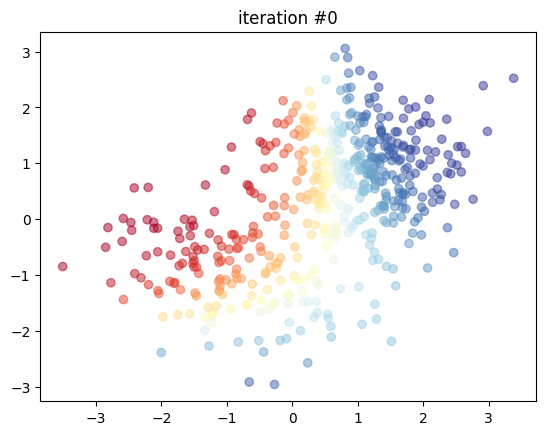

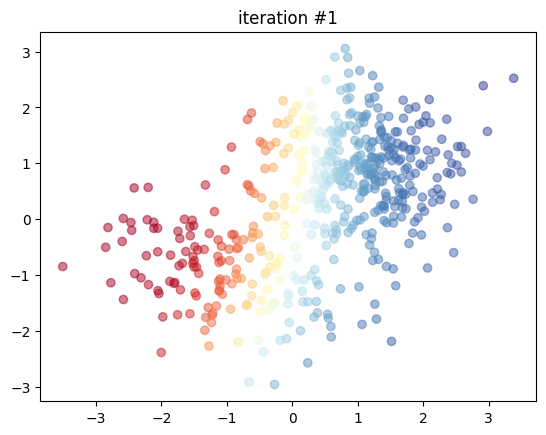

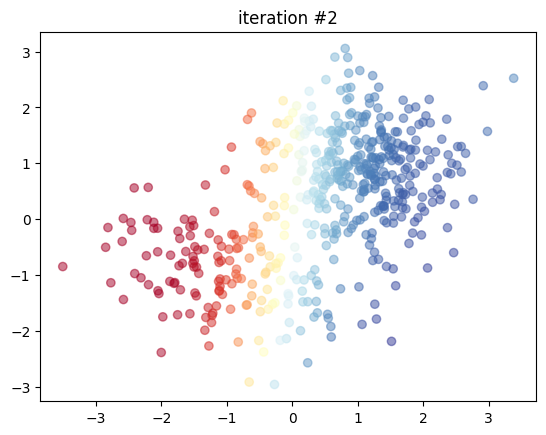

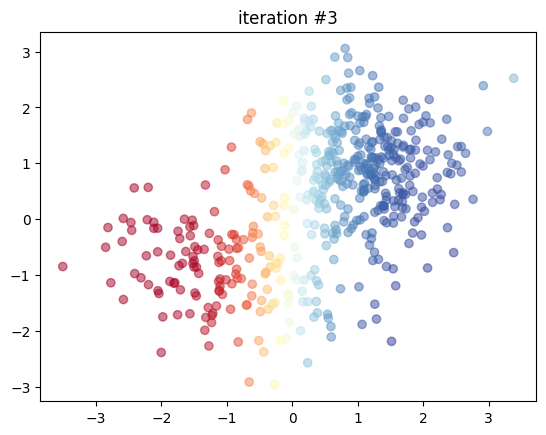

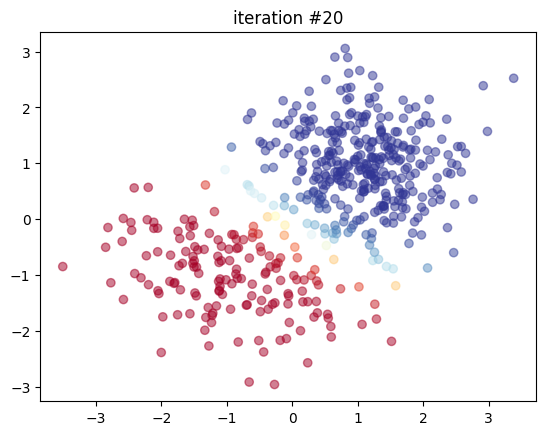

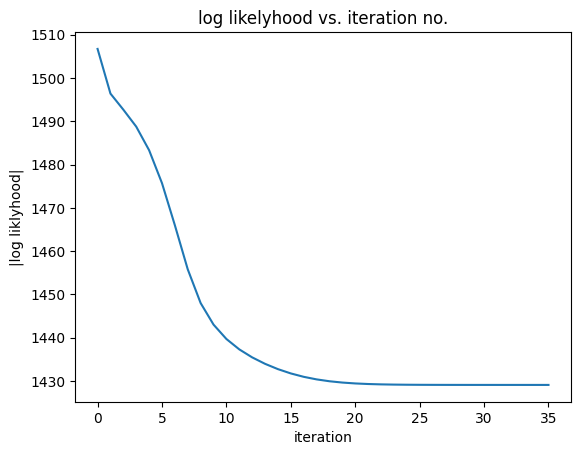

In [56]:

phi, mu, sigma, lol = MLE(data,init,case=1)

plot_log_likelihood(lol)

## Case II:
#### $\phi$ $\sigma$ and $\mu$ are unknown

in case 2, we are not given the variance matrecies, nor the probability for the first label, so we are looking for the centroids, $\mu$ and the variance matrecies $\sigma$ and the amplitude $\phi$
could it be that the algorithm will converge to the same values as in case 1?

sience we are not given the variance matrecies, we will have to calculate them at each iteration, using the centroids we found so far, and the labels we assigned to each datapoint.
we will initialize the model to a random gaussian distribution, and run the algorithm.

initiating a random model...
phi:  [0.49188476 0.50811524] 

mu:  [[-1.05185808 -0.38944742]
 [-0.19025086  0.69288115]] 

sigma:  [[[1.16258782 0.61219305]
  [0.61219305 0.43868319]]

 [[0.97865507 0.71638437]
  [0.71638437 0.52661607]]]


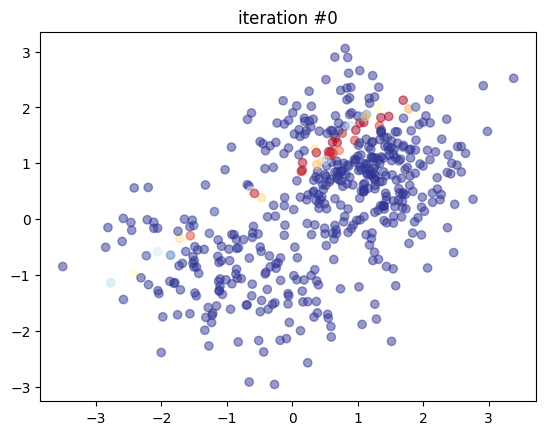

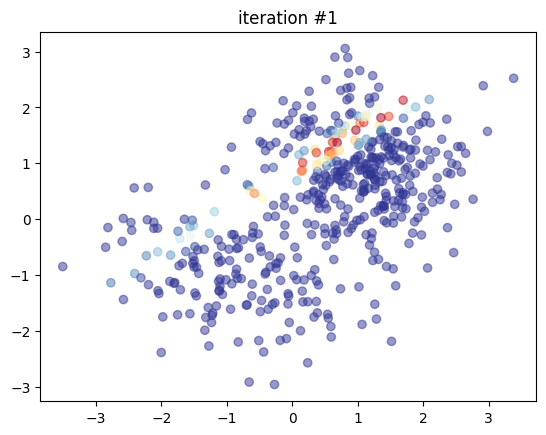

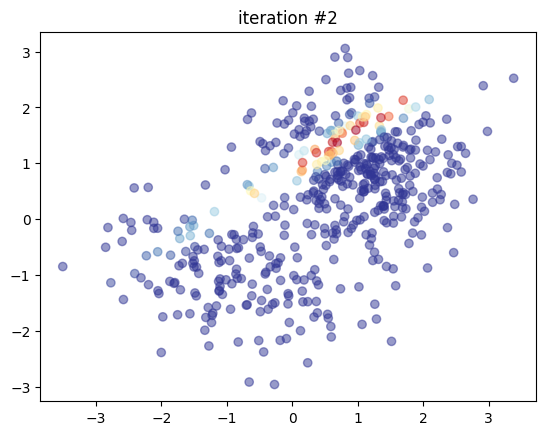

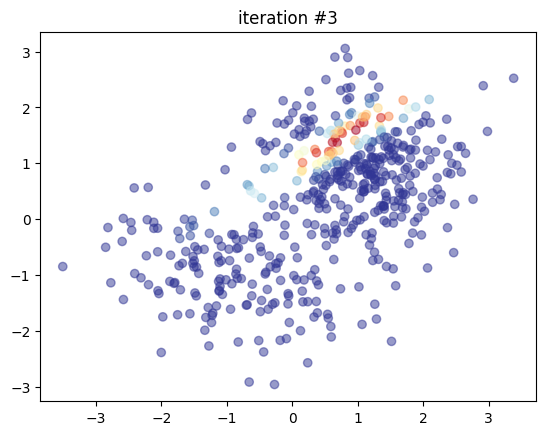

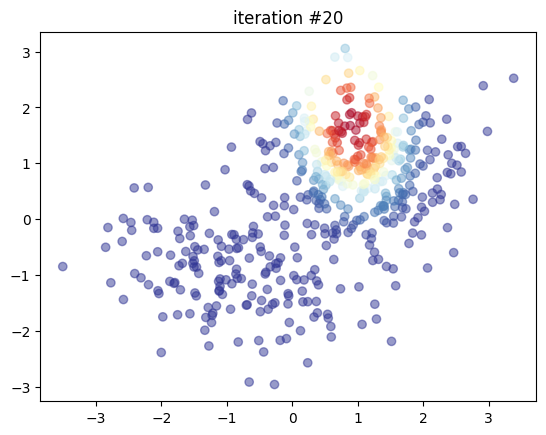

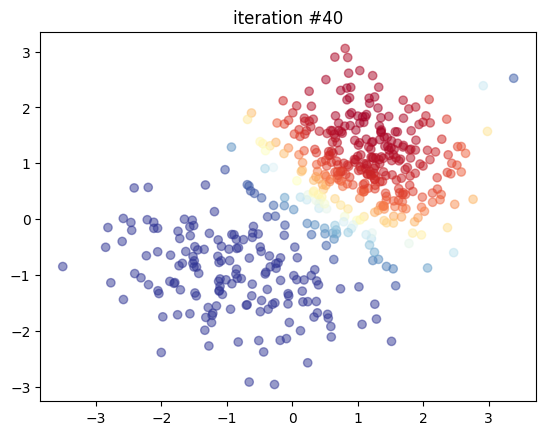

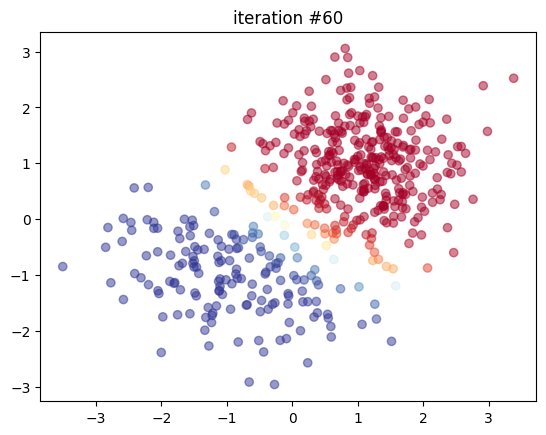

In [58]:
phi, mu, sigma, lol = MLE(data,initial_model(k,d),case=2)


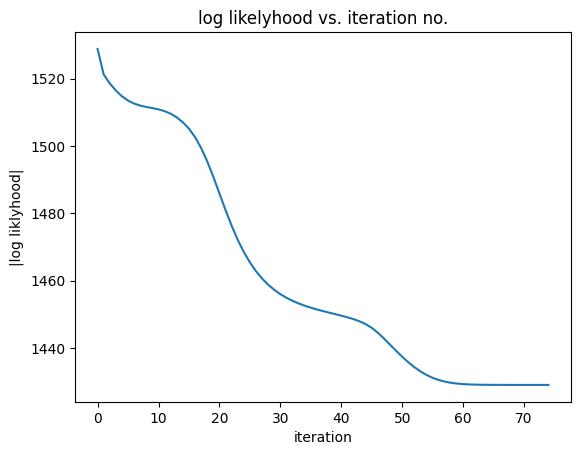

phi: [0.31602453 0.68397547]
mu: [[-0.88573161 -1.0043857 ]
 [ 1.04659846  0.93593871]]
sigma: [[[ 0.95294858 -0.23705585]
  [-0.23705585  0.49211161]]

 [[ 0.55737571 -0.01865886]
  [-0.01865886  0.55273546]]]


In [60]:
plot_log_likelihood(lol)

print(f'phi: {phi}\nmu: {mu}\nsigma: {sigma}')

### results
as we can clearly see, the initial guess was way off, but the algorithm converged to the actual values of the centroids, and the log likelyhood converged, although it took much more iterations to run (~80).

the model's parameters settle on the actual gaussians that are behind the data generation, and the log likelyhood converges, indicating that thealgorithm is likely to have stayed around said values, was it given even more iterations to run.

In [71]:
k=2         # number of clusters
d=3         # number of dimentions
N = 500    # number of datapoints


distribution_1 = get_random_gaussian_dist(d,distance=2)

distribution_2 = get_random_gaussian_dist(d,distance=2)

cluster_1 = generate_gaussian_cluster(distribution_1,int(phi[0]*N),d)
cluster_2 = generate_gaussian_cluster(distribution_2,int(phi[1]*N),d)

data = np.concatenate((cluster_1,cluster_2),axis=0)

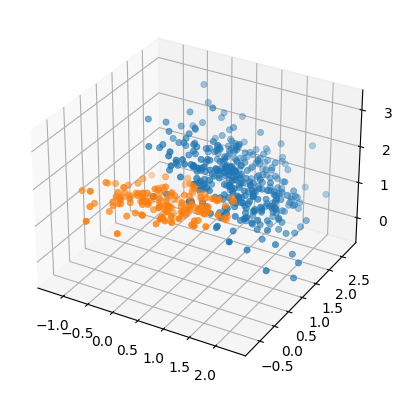

In [72]:
ax = plt.axes(projection='3d')
# scatter plot the points in the current cluster with the current color 🌈
ax.scatter(cluster_1[:,0],cluster_1[:,1],cluster_1[:,2], linewidth=0.5)
ax.scatter(cluster_2[:,0],cluster_2[:,1],cluster_2[:,2], linewidth=0.5)

initiating a model with given phi,sigma...
phi:  [3.24976518e-37 1.00000000e+00] 

mu:  [[ 0.08595476 -1.77981435 -1.12999001]
 [-0.21124109  0.5871876  -0.61000048]] 

sigma:  [array([[ 0.29454493,  0.08521417, -0.26265635],
       [ 0.08521417,  0.1658811 ,  0.00994119],
       [-0.26265635,  0.00994119,  0.33003897]]), array([[ 0.31417502,  0.05459178,  0.01449987],
       [ 0.05459178,  0.26420344, -0.11177761],
       [ 0.01449987, -0.11177761,  0.09846536]])]


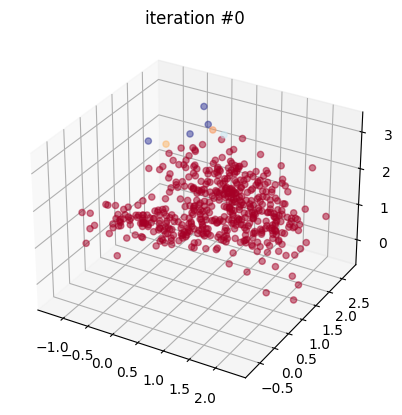

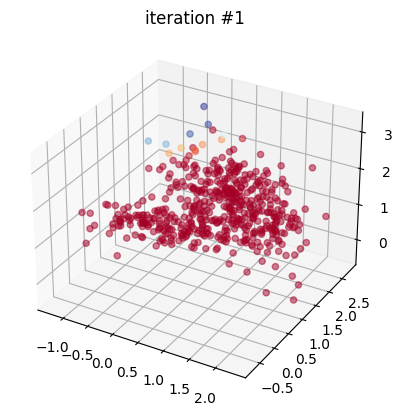

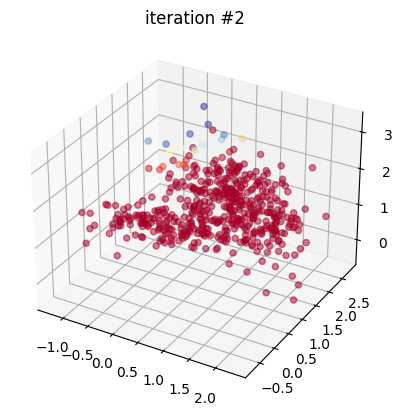

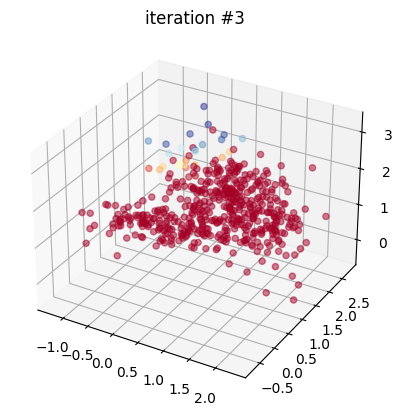

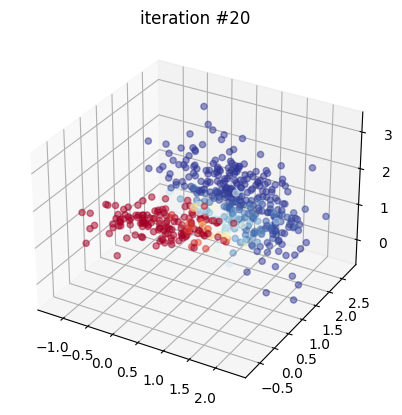

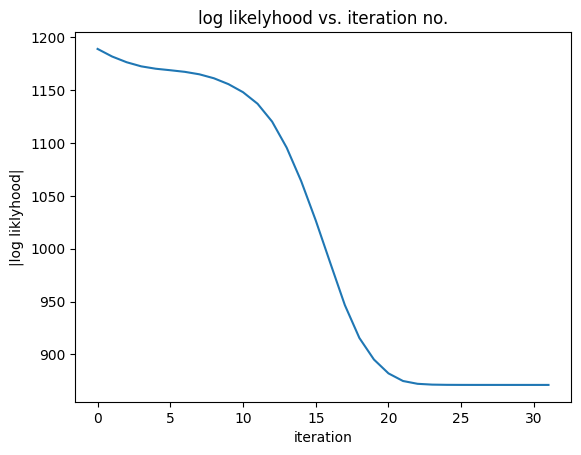

In [89]:
sigma = [distribution_1[1],distribution_2[1]]
init = initial_model(k,d,phi,sigma)


phi, mu, sigma, lol = MLE(data,init,case=1)
plot_log_likelihood(lol)

initiating a random model...
phi:  [0.55101655 0.44898345] 

mu:  [[-1.20929206 -2.4151105  -0.49526908]
 [-1.07281833 -1.24532299  1.09816913]] 

sigma:  [[[1.25576682 0.30278937 0.82165572]
  [0.30278937 0.78774114 0.14601801]
  [0.82165572 0.14601801 0.66198426]]

 [[1.8471744  1.65209232 0.50226731]
  [1.65209232 1.50038751 0.459187  ]
  [0.50226731 0.459187   0.71406054]]]


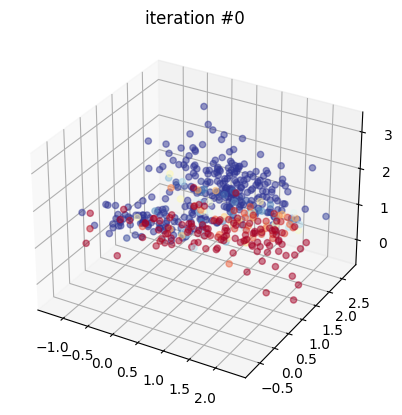

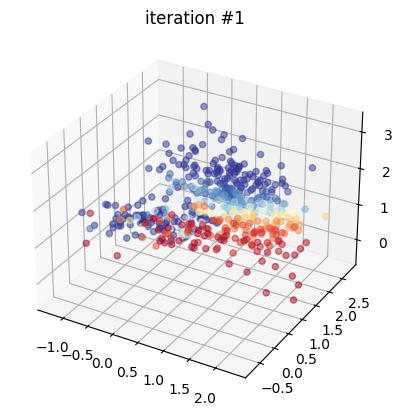

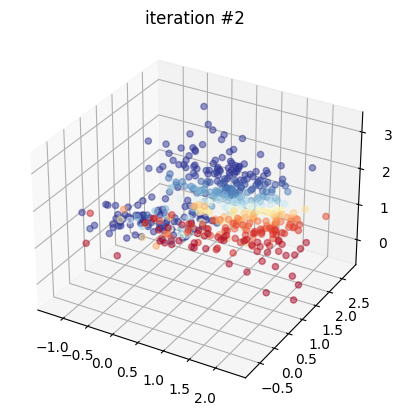

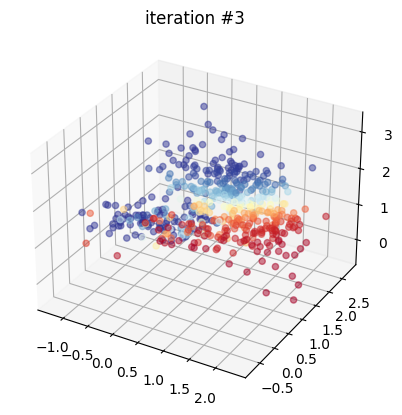

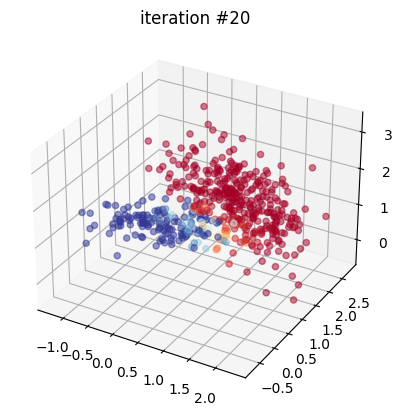

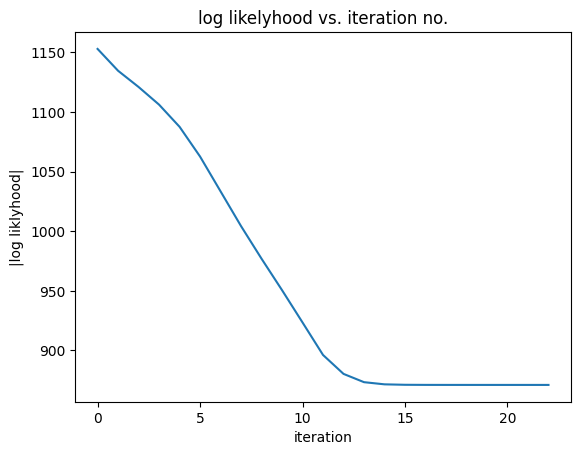

In [90]:
phi, mu, sigma, lol = MLE(data,initial_model(k,d),case=2)
plot_log_likelihood(lol)
